In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

## 1.数据说明

In [18]:
link_info_path = '../data/gy_link_info.txt'
link_top_path = '../data/gy_link_top.txt'
#link_travel_time_part1_path = '../data/gy_link_travel_time_part1.txt'
#link_travel_time_part2_path = '../data/gy_link_travel_time_part2.txt'
link_travel_time_part3_path = '../data/gy_link_travel_time_part3.txt'

In [19]:
# 道路的基本信息
link_infos = pd.read_csv(link_info_path,delimiter=';',dtype={'link_ID':object})
link_infos.head()

,link_ID,length,width,link_class
0,4377906289869500514,57,3,1
1,4377906284594800514,247,9,1
2,4377906289425800514,194,3,1
3,4377906284525800514,839,3,1
4,4377906284422600514,55,12,1


In [20]:
len(link_infos)

132

### link_info表中存储的是每天路的id,长度，宽度，类型，一共有132条路

In [21]:
# 每条路的上下游关系
link_tops = pd.read_csv(link_top_path,delimiter=';',dtype={'link_ID':object})
link_tops.head()

,link_ID,in_links,out_links
0,4377906289869500514,4377906285525800514,4377906281969500514
1,4377906284594800514,4377906284514600514,4377906285594800514
2,4377906289425800514,NaN,4377906284653600514
3,4377906284525800514,4377906281234600514,4377906280334600514
4,4377906284422600514,3377906289434510514#4377906287959500514,4377906283422600514


### link_tops表存储的是每一条路的上下游关系，中间用#分割

In [22]:
# 训练数据
#df_1 = pd.read_csv(link_travel_time_part1_path,delimiter=';',dtype={'link_ID':object})
#df_1.head()
# 可以看出df_1的数据日期区间是从2016-03-01 到 2016-06-30
# 可以看出df_2的数据日期区间是从2017-03-01 到 2017-06-30

In [23]:
#df_2 = pd.read_csv(link_travel_time_part2_path,delimiter=';',dtype={'link_ID':object})
df_3 = pd.read_csv(link_travel_time_part3_path,delimiter=';',dtype={'link_ID':object})
# 2016.4到6月每天的信息, 还有2017.7月每天6:00-8:00, 13:00-15:00, 16:00-18:00的记录

In [24]:
df_3.head()

,link_ID,date,time_interval,travel_time
0,4377906283422600514,2017-05-06,"[2017-05-06 11:04:00,2017-05-06 11:06:00)",3.0
1,3377906289434510514,2017-05-06,"[2017-05-06 10:42:00,2017-05-06 10:44:00)",1.0
2,3377906285934510514,2017-05-06,"[2017-05-06 11:56:00,2017-05-06 11:58:00)",35.2
3,3377906285934510514,2017-05-06,"[2017-05-06 17:46:00,2017-05-06 17:48:00)",26.2
4,3377906287934510514,2017-05-06,"[2017-05-06 10:52:00,2017-05-06 10:54:00)",10.4


## 2.数据分析

### 2.1 特征变换

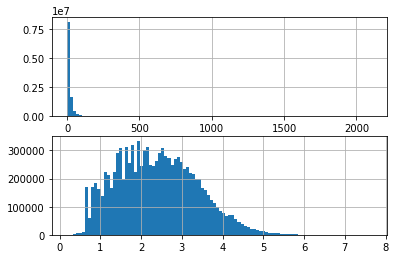

In [25]:
# 了解一下平均旅行时间的分布
fig,axes = plt.subplots(2,1)
df_3['travel_time'].hist(bins=100,ax = axes[0])
df_3['travel_time'] = np.log1p(df_3['travel_time'])
df_3['travel_time'].hist(bins=100,ax=axes[1])
plt.show()
# 可以发现平均旅行时间变量是一个长尾数据分布，大部分数据集中在很小的区域，对数变换ln(x+1),避免x=0的情况

### 2.2 数据平滑

In [26]:
# 即使log变换后，还有部分travel_time过大或者过小，为了消除一些离群点的影响，对travel_time进行百分位剪裁
def quantile_clip(group):
    #group.plot()
    group[group<group.quantile(0.05)] = group.quantile(0.05)
    group[group>group.quantile(0.95)] = group.quantile(0.95)
    #group.plot()
    #plt.show()
    return group

In [27]:
df_3['travel_time'] = df_3.groupby(['link_ID','date'])['travel_time'].transform(quantile_clip)

In [28]:
# 将date截取时间范围的前一刻
df_3['time_interval_begin'] = pd.to_datetime(df_3['time_interval'].map(lambda x:x[1:20]))

In [29]:
df_3.head()

,link_ID,date,time_interval,travel_time,time_interval_begin
0,4377906283422600514,2017-05-06,"[2017-05-06 11:04:00,2017-05-06 11:06:00)",1.386294,2017-05-06 11:04:00
1,3377906289434510514,2017-05-06,"[2017-05-06 10:42:00,2017-05-06 10:44:00)",0.693147,2017-05-06 10:42:00
2,3377906285934510514,2017-05-06,"[2017-05-06 11:56:00,2017-05-06 11:58:00)",3.589059,2017-05-06 11:56:00
3,3377906285934510514,2017-05-06,"[2017-05-06 17:46:00,2017-05-06 17:48:00)",3.303217,2017-05-06 17:46:00
4,3377906287934510514,2017-05-06,"[2017-05-06 10:52:00,2017-05-06 10:54:00)",2.251292,2017-05-06 10:52:00


### 2.3 缺失值补全

In [30]:
# 时间序列预测，需要根据前几个时刻的travel_time预测下一个时刻的travel_time，一定要将缺失值补全
# 方法：训练已有的数据，把缺失的数据当做要预测的数据
#原始的数据集中 ，缺失的时间序列是没有出现在数据集中的，需要手动插入，然后把travel_time用nan标识出来，需要找到这些缺失信息

####  2.3.1 找到缺失值 

In [31]:
# link_infos 存储道路的基本信息
# data_range 用来获取完整的间隔时间
# 
date_range = pd.date_range("2016-07-01 00:00:00", "2016-07-31 23:58:00", freq='2min').append(
    pd.date_range("2017-04-01 00:00:00", "2017-07-31 23:58:00", freq='2min'))

new_index = pd.MultiIndex.from_product([link_infos['link_ID'].unique(),date_range],names = ['link_ID','time_interval_begin'])
df1 = pd.DataFrame(index = new_index).reset_index()
df3 = pd.merge(df1,df_3,on=['link_ID','time_interval_begin'],how='left')

In [32]:
# 因为要预测的是2017年每月的第8，15，18小时，认为每个时段的前两个小时的数据比较重要
# 只选择每天6，7，8，13，14，15，16，17，18小时，然后去掉2017年7月每天的第8，15，18小时
df3 = df3.loc[(df3['time_interval_begin'].dt.hour.isin([6, 7, 8, 13, 14, 15, 16, 17, 18]))]
df3 = df3.loc[~((df3['time_interval_begin'].dt.year == 2017) & (df3['time_interval_begin'].dt.month == 7) & (
    df3['time_interval_begin'].dt.hour.isin([8, 15, 18])))]

df3['date'] = df3['time_interval_begin'].dt.strftime('%Y-%m-%d')

#df3.loc[df3['travel_time'].isnull() == True].groupby('date')['link_ID'].count()

df_miss_date = df3.loc[df3['travel_time'].isnull() == True].groupby('date')['link_ID'].count()
#plt.show()


In [42]:
len(df_miss_date)

153

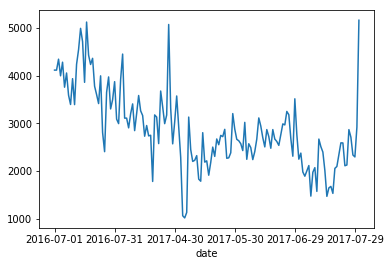

In [47]:
df_miss_date.plot(xticks=list(range(0,153,30)))
plt.show()

In [48]:
# 可以看出2016年7月的数据缺失较多，并且2016年7月距离2017年4月中间相隔好几个月，不连续
# 一个更好的办法是用2017年3月份的数据代替2016年7月份的数据，即用2017年3，4，5，6四个月的数据预测7月份的数据
link_travel_time_part2_path = '../data/gy_link_travel_time_part2.txt'
df_2 = pd.read_csv(link_travel_time_part2_path,delimiter=';',dtype={'link_ID':object})
# 这个之后在代码中显示

### 接下来要做的是补全缺失值，其中需要考虑到季节性趋势 和 天的趋势，然后利用lightGBM预测缺失值，但是首先要做的是处理数据，根据之前的分析结果，需要合并数据，利用2017年3，4，5，6四个月的数据预测7月份的数据